In [12]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_samples, silhouette_score

import geopandas as gpd

In [3]:
uber = pd.read_csv('uber-raw-data-aug14.csv')

In [4]:
uber.Base.value_counts()

B02617    355803
B02598    220129
B02682    173280
B02764     48591
B02512     31472
Name: Base, dtype: int64

In [5]:
uber['Date/Time'] = pd.to_datetime(uber['Date/Time'])
uber.set_index('Date/Time', inplace=True)


In [6]:
uber_coord = uber.drop('Base', axis=1)

In [7]:
uber_coord.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 829275 entries, 2014-08-01 00:03:00 to 2014-08-31 23:59:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Lat     829275 non-null  float64
 1   Lon     829275 non-null  float64
dtypes: float64(2)
memory usage: 19.0 MB


In [8]:
sc = StandardScaler()
uber_coord_sc = pd.DataFrame(sc.fit_transform(uber_coord), columns=uber_coord.columns, index=uber_coord.index)


In [9]:
resultats = {}

for n in range(2,22):
    km = MiniBatchKMeans(n_clusters=n).fit(uber_coord_sc)
    resultats[n] = km.inertia_


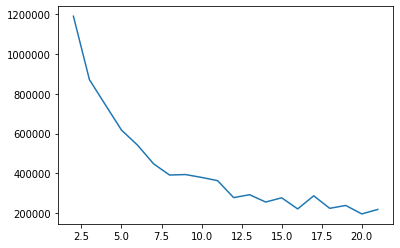

In [10]:
_ = sns.lineplot(x=list(resultats.keys()), y=list(resultats.values()))

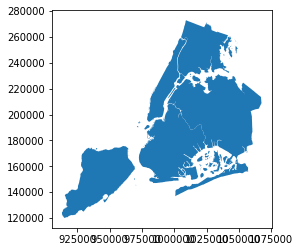

In [19]:
nybb = gpd.read_file(gpd.datasets.get_path('nybb'))
nybb.plot()

In [14]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(uber_coord.Lon, uber_coord.Lat)]


In [17]:

# crs="EPSG:4326", 
geo_uber = gpd.GeoDataFrame(uber_coord.iloc[:10000, :-1], crs="EPSG:4326", geometry=geometry[:10000])

nybb = nybb.to_crs("init=epsg:4326") 


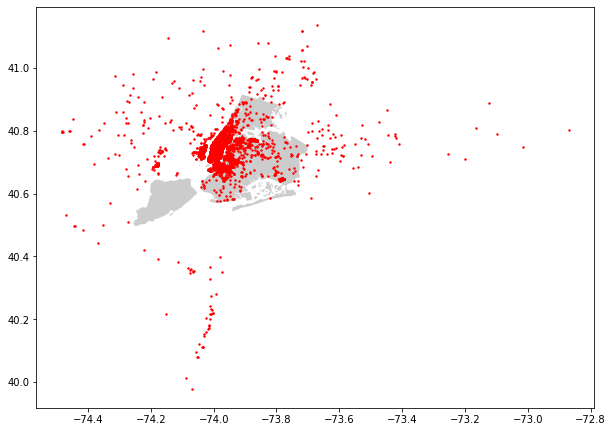

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

nybb.plot(ax=ax, alpha=.4, color='grey')

geo_uber.iloc[:10000].plot(ax=ax, markersize=2, color='red')

In [20]:
km = MiniBatchKMeans(n_clusters=3).fit(uber_coord_sc)

In [21]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent="jedha_bootcamp_uber_stats")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)


In [22]:
[geocode([lat,lon]) for lat,lon in sc.inverse_transform(km.cluster_centers_)]

[Location(46, Eldridge Street, Chinatown, Manhattan, Manhattan Community Board 3, New York County, New York, 10002, United States of America, (40.7158652, -73.99289150705685, 0.0)),
 Location(132, East 73rd Street, Upper East Side, Manhattan, Manhattan Community Board 8, New York County, New York, 10021, United States of America, (40.771151700000004, -73.96231614423937, 0.0)),
 Location(Rockaway Boulevard, Laurelton, Bayswater, New York, Queens County, New York, 11422:11434, United States of America, (40.6538094, -73.7632453, 0.0))]

In [101]:
for nc in range(2,11):

    km = MiniBatchKMeans(n_clusters=nc).fit(uber_coord_sc)

    print('*'*60)
    print('pour nb cluster = ' + str(nc))
    for r in [geocode([lat,lon]) for lat,lon in sc.inverse_transform(km.cluster_centers_)]:
        print(r)
    print()


************************************************************
pour nb cluster = 2
286, 3rd Avenue, East Village, Gramercy, Manhattan Community Board 6, New York County, New York, 10010, United States of America
Meadow Lake, Meadow Lake East Road, Queens, New York, Queens County, New York, 11367, United States of America

************************************************************
pour nb cluster = 3
1, East 64th Street, Lenox Hill, Manhattan, Manhattan Community Board 8, New York County, New York, 10065, United States of America
201, Clinton Street, Lower East Side, Manhattan, Manhattan Community Board 3, New York County, New York, 10002, United States of America
153-23, 123rd Avenue, Cedar Manor Houses, Queens, New York, Queens County, New York, 11434, United States of America

************************************************************
pour nb cluster = 4
40, Prince Street, SoHo, Manhattan, Manhattan Community Board 2, New York County, New York, 10012, United States of America
Lee A

In [102]:
[(lat,lon) for lat,lon in sc.inverse_transform(km.cluster_centers_)]

# pour injection manuelle dans Google map

[(40.749941007751936, -73.98419403100775),
 (40.70464532224532, -73.94849563409564),
 (40.76288577075099, -73.9602118577075),
 (40.72417244772448, -73.99960504305044),
 (40.77449791666667, -73.85458708333333),
 (40.69394259259259, -74.20811666666667),
 (40.765654352441615, -73.98850445859873),
 (40.79855984555984, -73.95459131274131),
 (40.65696627906976, -73.75571395348837),
 (40.66348005464481, -73.98063224043716)]

In [23]:
uber_coord_sc['hour'] = uber_coord_sc.index.hour
uber_coord_sc['dayofweek'] = uber_coord_sc.index.dayofweek


In [24]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap

In [25]:
gamme_de_bleu = ['#0094fb','#199efb', '#32a9fb','#4cb4fc', '#66befc','#7fc9fd', '#99d4fd','#b2defd','#cce9fe','#e5f4fe']

output_file("gmap_kmeans_jours_de_la_semaine.html")
map_options = GMapOptions(lat=40.749941007751936, lng=-73.98419403100775, map_type="roadmap", zoom=11)
p = gmap("API-KEY", map_options, title="NYC", plot_width=1000 )

for h in range(0,6):
    km = MiniBatchKMeans(n_clusters=3).fit(uber_coord_sc.iloc[:,:-2][uber_coord_sc['dayofweek']==h])

    source = ColumnDataSource(
    data=dict(lat=[lat for lat,lon in sc.inverse_transform(km.cluster_centers_)],
              lon=[lon for lat,lon in sc.inverse_transform(km.cluster_centers_)])
    )

    p.circle(x="lon", y="lat", size=30, line_color=gamme_de_bleu[h%10], fill_color=gamme_de_bleu[h%10], fill_alpha=0.4, source=source)
    
    
show(p)


In [26]:
# periode de la journéee

def periode_jour(h):
    nuit = [1,2,3,4,5,6]
    matin = [7,8,9,10,11,12]
    apresmidi = [12,14,15,16,17,18]
    soir = [19,20,21,22,23,0]

    if h in nuit:
        return 'nuit'
    elif h in matin:
        return 'matin'
    elif h in apresmidi:
        return 'apres midi'
    else:
        return 'soir'

uber_coord_sc['moment'] = uber_coord_sc.hour.apply(lambda x : periode_jour(x))



In [27]:
gam_couleur = {'nuit':'black', 'matin' :'blue', 'apres midi':'yellow', 'soir':'red'}

output_file("gmap_kmeans_moment_de_la_journee.html")
map_options = GMapOptions(lat=40.749941007751936, lng=-73.98419403100775, map_type="roadmap", zoom=11)
p = gmap("API-KEY", map_options, title="NYC", plot_width=1000 ,tools=['hover', 'reset', 'wheel_zoom', 'pan'])

for h in ['nuit', 'matin', 'apres midi', 'soir']:
    km = MiniBatchKMeans(n_clusters=4).fit(uber_coord_sc.iloc[:,:-3][uber_coord_sc['moment']==h])

    source = ColumnDataSource(
    data=dict(lat=[lat for lat,lon in sc.inverse_transform(km.cluster_centers_)],
              lon=[lon for lat,lon in sc.inverse_transform(km.cluster_centers_)])
    )

    p.circle(x="lon", y="lat", size=30, line_color=gam_couleur[h], fill_color=gam_couleur[h], fill_alpha=0.4, source=source)
    
    
show(p)

## DBSCAN

In [6]:
from sklearn.cluster import DBSCAN


In [ ]:
uber_coord['dayofweek'] = uber_coord.index.dayofweek

In [97]:
subs = uber_coord[uber_coord['dayofweek']==0]

In [98]:
subs.shape

(91633, 3)

In [99]:
dbs = DBSCAN(eps=0.005, min_samples=500, metric='manhattan').fit(subs)

In [100]:
core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
core_samples_mask[dbs.core_sample_indices_] = True
labels = dbs.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 20411


In [103]:

a_tracer = {}
for i in range(0,n_clusters_):
    class_member_mask = (labels == i)
    xy = subs[class_member_mask & core_samples_mask]
    print('({},{})'.format(xy.mean()[0], xy.mean()[1]))
    print('nombre de points : {}'.format(len(xy)))
    print()
    a_tracer[i] = (xy.mean()[0], xy.mean()[1], len(xy))

(40.745294899400356,-73.98782657789506)
nombre de points : 58052

(40.694403610108296,-74.17789277978336)
nombre de points : 554

(40.645648726541076,-73.78274872654133)
nombre de points : 2984

(40.77176341463409,-73.86818060975612)
nombre de points : 2460

(40.71645854700853,-73.960561965812)
nombre de points : 234



In [158]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap

import itertools  
from bokeh.palettes import Dark2_5 as palette
colors = itertools.cycle(palette)  

output_file("gmap.html")

map_options = GMapOptions(lat=40.749941007751936, lng=-73.98419403100775, map_type="roadmap", zoom=11)
p = gmap("API-KEY", map_options, title="NYC", plot_width=1000 ,tools=['hover', 'reset', 'wheel_zoom', 'pan'])

for h,color in zip(a_tracer.items(),colors):
    source = ColumnDataSource(data=dict(lat=[h[1][0]], lon=[h[1][1]]))
    p.circle(x="lon", y="lat", size=np.log(h[1][2])*5, color=color, fill_alpha=0.4, source=source)
    
show(p)

### boucle sur le jour de la semaine

In [141]:
for dow in range(0,7):
    subs = uber_coord[uber_coord['dayofweek']==dow]

    dbs = DBSCAN(eps=0.005, min_samples=500, metric='manhattan').fit(subs)

    core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
    core_samples_mask[dbs.core_sample_indices_] = True
    labels = dbs.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)

    a_tracer = {}
    for i in range(0,n_clusters_):
        class_member_mask = (labels == i)
        xy = subs[class_member_mask & core_samples_mask]
        print('({},{})'.format(xy.mean()[0], xy.mean()[1]))
        print('nombre de points : {}'.format(len(xy)))
        print()
        a_tracer[i] = (xy.mean()[0], xy.mean()[1], len(xy))


    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(a_tracer))]

    output_file("gmap_{}.html".format(dow))

    map_options = GMapOptions(lat=40.749941007751936, lng=-73.98419403100775, map_type="roadmap", zoom=11)
    p = gmap("API-KEY", map_options, title="NYC", plot_width=1000 ,tools=['hover', 'reset', 'wheel_zoom', 'pan'])

    for h in a_tracer.items():
        source = ColumnDataSource(data=dict(lat=[h[1][0]], lon=[h[1][1]]))
        p.circle(x="lon", y="lat", size=np.log(h[1][2])*5, line_color=colors[h[0]], fill_color=colors[h[0]], fill_alpha=0.4, source=source)
        
    show(p)



Estimated number of clusters: 5
Estimated number of noise points: 33456
(40.74258690754625,-73.98961162894638)
nombre de points : 58148

(40.716449172141935,-73.95823752956613)
nombre de points : 3805

(40.694029775280875,-74.1779026685394)
nombre de points : 712

(40.6451987086173,-73.78361441652974)
nombre de points : 4259

(40.77190277290277,-73.86845282555272)
nombre de points : 2849



### boucle sur le moment de la journée

In [172]:
uber_coord['hour'] = uber_coord.index.hour
uber_coord['moment'] = uber_coord.hour.apply(lambda x : periode_jour(x))


In [184]:
uber_coord_sub = uber_coord[uber_coord.index < "2014-08-20"]

In [182]:
uber_coord_sub[uber_coord_sub['moment'] == 'nuit'].iloc[:,:-3]

Lat      Lon
Date/Time                            
2014-08-01 01:01:00  40.7585 -73.9732
2014-08-01 01:08:00  40.7711 -73.9832
2014-08-01 01:09:00  40.7133 -74.0092
2014-08-01 01:11:00  40.7222 -73.9588
2014-08-01 01:19:00  40.7399 -74.0024
...                      ...      ...
2014-08-14 06:49:00  40.6230 -73.9781
2014-08-14 06:51:00  40.7704 -73.9644
2014-08-14 06:54:00  40.7797 -73.9518
2014-08-14 06:55:00  40.7705 -73.9840
2014-08-14 06:59:00  40.7667 -73.9517

[41178 rows x 2 columns]

In [186]:
for moment in ['nuit', 'matin', 'apres midi', 'soir']:
    subs = uber_coord_sub[uber_coord_sub['moment'] == moment].iloc[:,:-3]

    dbs = DBSCAN(eps=0.005, min_samples=500, metric='manhattan').fit(subs)

    core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
    core_samples_mask[dbs.core_sample_indices_] = True
    labels = dbs.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)

    a_tracer = {}
    for i in range(0,n_clusters_):
        class_member_mask = (labels == i)
        xy = subs[class_member_mask & core_samples_mask]

        print('({},{})'.format(xy.mean()[0], xy.mean()[1]))
        print('nombre de points : {}'.format(len(xy)))
        print()
        
        a_tracer[i] = (xy.mean()[0], xy.mean()[1], len(xy))


    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(a_tracer))]

    output_file("gmap_{}.html".format(moment))

    map_options = GMapOptions(lat=40.749941007751936, lng=-73.98419403100775, map_type="roadmap", zoom=11)
    p = gmap("API-KEY", map_options, title="NYC", plot_width=1000 ,tools=['hover', 'reset', 'wheel_zoom', 'pan'])

    for h in a_tracer.items():
        source = ColumnDataSource(data=dict(lat=[h[1][0]], lon=[h[1][1]]))
        p.circle(x="lon", y="lat", size=np.log(h[1][2])*5, line_color=colors[h[0]], fill_color=colors[h[0]], fill_alpha=0.4, source=source)
        
    show(p)

Estimated number of clusters: 6
Estimated number of noise points: 20208
(40.73680857426823,-73.99330378117118)
nombre de points : 22136

(40.645270033296065,-73.78214683684783)
nombre de points : 901

(40.77295549132954,-73.95551637764926)
nombre de points : 1038

(40.77790434782607,-73.98059130434785)
nombre de points : 46

(40.71890025773199,-73.95774845360832)
nombre de points : 388

(40.7139,-73.9635)
nombre de points : 1

Estimated number of clusters: 6
Estimated number of noise points: 26456
(40.74802781920521,-73.98527408767731)
nombre de points : 80865

(40.692586046511636,-73.98540155038752)
nombre de points : 129

(40.77162975088968,-73.86799014234877)
nombre de points : 2810

(40.71590357366773,-73.96011448275857)
nombre de points : 1595

(40.64513550387577,-73.78216294573633)
nombre de points : 645

(40.69421100917435,-74.17787798165143)
nombre de points : 109

Estimated number of clusters: 7
Estimated number of noise points: 27499
(40.6450619373519,-73.78429797315088)
nomb